In [2]:
import os
import torch
from ddpm import model
import matplotlib.pyplot as plt

from ddpm.utils.loading import generate_model_and_task_from_args_path

device = 'cuda'

Here we are testing whether a network can have the same generation behaviour when running the same noise schedule sequentially

To test this properly, we start with models which have a single (diffusion) epoch - no prep time at all

In [3]:
device = 'cuda'
load_path = '/homes/pr450/repos/research_projects/error_modelling_torus/results_link_sampler/ddpm_recoup_20250108/run_h_teacher_forced_causal_inference_0'
_, task, ddpm_model, _ = generate_model_and_task_from_args_path(os.path.join(load_path, 'args.yaml'), device)
ddpm_model.load_state_dict(torch.load(os.path.join(load_path, 'state.mdl')))

/tmp/ipykernel_921467/2182043530.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm_model.load_state_dict(torch.load(os.path.join(load_path, 'state.mdl')))


<All keys matched successfully>

100%|██████████| 512/512 [00:14<00:00, 35.35it/s]


Text(0.5, 1.0, '')

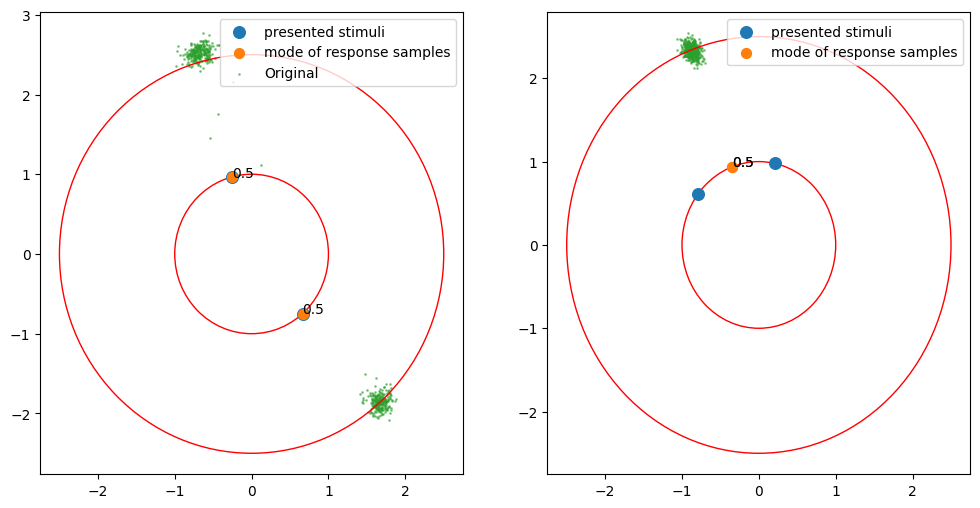

In [20]:
from tqdm import tqdm

num_sample_chains = 1
num_sequential_samples = 512


trial_information = task.generate_trial_information(batch_size=2, num_samples=1)
network_inputs = trial_information.network_inputs.repeat(1, num_sample_chains, 1)

# Initial sample
novel_samples_dict = ddpm_model.generate_samples(
    network_input = network_inputs,
    samples_shape = [2, num_sample_chains],
)

all_sequential_samples = []

for _ in tqdm(range(num_sequential_samples)):
    
    novel_samples_dict = ddpm_model.generate_samples(
        network_input = network_inputs,
        base_samples = novel_samples_dict['end_state'],
    )
    all_sequential_samples.append(novel_samples_dict['samples'])

all_sequential_samples = torch.concat(all_sequential_samples, 1) # [batch (2), num sequential, y (2)]


fig,axes = plt.subplots(1, 2, figsize = (12, 6))
for i in range(2):
    task.task_variable_gen.display_task_variables(trial_information.task_variable_information, axes[i], batch_idx=i)
    task.sample_gen.display_samples(all_sequential_samples[[i]], axes[i], label = 'Original')

axes[0].legend()

axes[0].set_title('')
axes[1].set_title('')